### Comparing the blue light available at different depths (m)
 This notebook uses historical surface PAR data from the Humboldt Bay Pier (NDBC: HBXC1) to calculate light attenuation at different depths where bull kelp gametophytes could settle, fertilize, and grow. The historical data needed for this analysis is found on the [California Ocean Observing Systems Data Portal](https://data.caloos.org/#metadata/20363/station/data).

### Introduction

Outline

Background

Bull kelp:
- Bull kelp distribution and habitat
- Bull kelp life cycle and microscopic stages (gametophytes)
- input diagram of bull kelp life cycle and growth
- define photomorphogenesis ie light quality determines morphological structures and biological processes
- define gametogenesis vs dormancy
- seasonality: gametophytes go dormant and fertilize in the winter  
- The availability/amount of blue light determines whether gametophytes will fertilize

Light attenuation:
- define light attenuation in the water column
- input light attentuation diagram
- other factors that impact blue light availability (canopy, light flecking, turbidity, sedimentation, photoperiod)

Goals:
- Objective: to understand the range of blue light and determine the range of depth where bull kelp gametophytes can fertilize
- Hypothesis: I hypothesize that the amount of PAR in the blue light spectrum at depths 5m, 10m, 15m, and 40m will be different 

### Methods 

- Search for PAR data online that is on the coast
- Describe surface radiation and how it can be used in this context (beer lampert law)
- Describe California Ocean Observing Systems Data Portal

### Results 

Formatting the raw data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal.windows import hann
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('humboldt_PAR.csv')

/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/3119043566.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('humboldt_PAR.csv')


In [4]:
df = pd.read_csv('humboldt_PAR.csv')
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)

print(df[df['time'].isnull()])

start_date = pd.to_datetime('2023-11-01T00:00:00Z')
end_date = pd.to_datetime('2024-05-01T00:00:00Z')

subset = (df['time'] >= start_date) & (df['time'] <= end_date)

new_df = df.loc[subset, ['time', 'surface_downwelling_photosynthetic_photon_flux_in_air']]

print(new_df)

/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/160079394.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('humboldt_PAR.csv')
/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/160079394.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)


  time surface_downwelling_photosynthetic_photon_flux_in_air  \
0  NaT                                   micromol.m-2.s-1      

   surface_downwelling_photosynthetic_photon_flux_in_air_qc_agg  z  
0                                                NaN             m  
                            time  \
237988 2023-11-01 00:00:00+00:00   
237989 2023-11-01 00:15:00+00:00   
237990 2023-11-01 00:30:00+00:00   
237991 2023-11-01 00:45:00+00:00   
237992 2023-11-01 01:00:00+00:00   
...                          ...   
255417 2024-04-30 23:00:00+00:00   
255418 2024-04-30 23:15:00+00:00   
255419 2024-04-30 23:30:00+00:00   
255420 2024-04-30 23:45:00+00:00   
255421 2024-05-01 00:00:00+00:00   

       surface_downwelling_photosynthetic_photon_flux_in_air  
237988                                             300.62     
237989                                              175.6     
237990                                             192.82     
237991                                          

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22731/3052153819.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Surface PAR ($\mu$mol m$^{-2}$ s$^{-1}$")')


Text(0.5, 1.0, 'Surface Downwelling Shortwave Flux in Humboldt from November 2023 to May 2024')

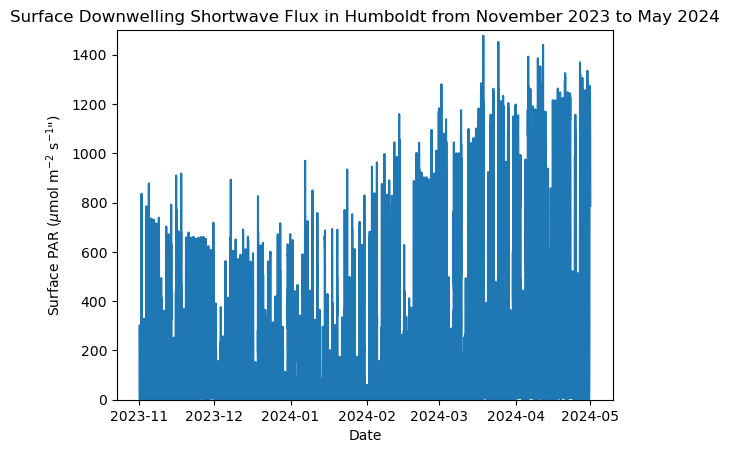

In [4]:
#plotting the raw data
plt.figure()
plt.plot(new_df['time'], new_df['surface_downwelling_photosynthetic_photon_flux_in_air'], '-')
plt.ylim(0, 1500)
plt.xlabel('Date')
plt.ylabel('Surface PAR ($\mu$mol m$^{-2}$ s$^{-1}$")')
plt.title('Surface Downwelling Shortwave Flux in Humboldt from November 2023 to May 2024')

In [5]:
#Creating a new file of the subsetted data to analyze instead of the raw data
output_file = 'subset_data_2023_11_to_2024_05.csv'
new_df.to_csv(output_file, index=False)
print(f"Subset data saved to: {output_file}")

Subset data saved to: subset_data_2023_11_to_2024_05.csv


In [6]:
#Creating a new subset of data that only includes months 11/2023 - 5/2024
df_2 = pd.read_csv('subset_data_2023_11_to_2024_05.csv')

### Analyzing the data from the new data file 

In [7]:
#Importing function
import sys
sys.path.append('/Users/nataliecolao@Natalies-MacBook-Pro-2/desktop/python/Final_project_data/draft_project')
import beer_lampert_law as bll

#The next line removes the NaN values from the dataset
cleaned_data = df_2.dropna(subset=['surface_downwelling_photosynthetic_photon_flux_in_air'])

surface_irradiance = cleaned_data['surface_downwelling_photosynthetic_photon_flux_in_air']
depths = [5.0, 10.0, 20.0, 40.0]
attenuation_coefficient = 0.004 #this value is the blue light wavelength

for depth in depths:
    new_column = f'irradiance_at_{int(depth)}m' #this is creating new columns with the irradiance at each depth 
    cleaned_data[new_column] = bll.beer_lampert_law(surface_irradiance, attenuation_coefficient, depth) #this applies the function to the dataset without NaN values
    

/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/4109990006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[new_column] = bll.beer_lampert_law(surface_irradiance, attenuation_coefficient, depth) #this applies the function to the dataset without NaN values
/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/4109990006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[new_column] = bll.beer_lampert_law(surface_irradiance, attenuation_coefficient, 

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/lx/3_b4m24d74df5ymsjfzb4vjr0000gn/T/ipykernel_22801/1344976665.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('PAR ($\mu$mol m$^{-2}$ s$^{-1}$")')


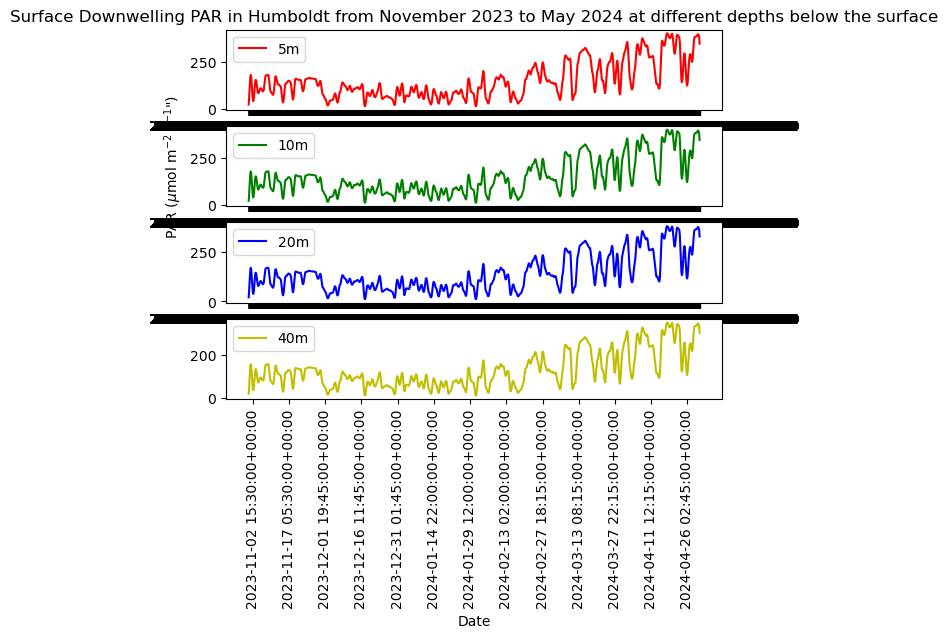

In [25]:
#smoothing the time series
window = hann(4*48)#is how many time steps want to smooth it. 15 min intervales in a day , 48 is two day window and there are 4 15 min intervals in one hour
window = window/np.sum(window)

plt.figure()
plt.subplot(4, 1, 1)
cleaned_data_smooth_5m = np.convolve(cleaned_data['irradiance_at_5m'], window, mode = 'same')
plt.plot(cleaned_data['time'], cleaned_data_smooth_5m, 'r-', label='5m')
plt.xlabel('Date')
plt.title('Surface Downwelling PAR in Humboldt from November 2023 to May 2024 at different depths below the surface')
#plt.gca().set_xticklabels([])
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()

plt.subplot(4, 1, 2)
cleaned_data_smooth_10m = np.convolve(cleaned_data['irradiance_at_10m'], window, mode = 'same')
plt.plot(cleaned_data['time'], cleaned_data_smooth_10m, 'g-', label='10m')
plt.xlabel('Date')
plt.ylabel('PAR ($\mu$mol m$^{-2}$ s$^{-1}$")')
#plt.gca().set_xticklabels([]) 
plt.legend()

plt.subplot(4, 1, 3)
cleaned_data_smooth_20m = np.convolve(cleaned_data['irradiance_at_20m'], window, mode = 'same')
plt.plot(cleaned_data['time'], cleaned_data_smooth_20m, 'b-', label='20m')
plt.xlabel('Date')
#plt.gca().set_xticklabels([]) 
plt.legend()

plt.subplot(4, 1, 4)
cleaned_data_smooth_40m = np.convolve(cleaned_data['irradiance_at_40m'], window, mode = 'same')
plt.plot(cleaned_data['time'], cleaned_data_smooth_40m, 'y-', label='40m')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0, interval=200)) 
plt.xticks(rotation=90)
plt.legend()


### Map of Humboldt Bay Pier 

In [ ]:
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

# map extent for Humboldt bay pier
extent = [-124.6,-124, 41, 40.5]
pin_lon = -124.1965
pin_lat = 40.7775

request = cimgt.GoogleTiles(style='satellite') #inserting google map

plt.figure()
ax = plt.axes(projection=ccrs.Mercator())

ax.coastlines()
ax.add_image(request, 12)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

ax.plot(pin_lon, pin_lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())

ax.set_extent(extent, crs=ccrs.PlateCarree())

### Statistical Analyses

I am using a repeated measures ANOVA to compare the irradianceds at each depth because the values to calculate irradiance at each depth were taken at the same time and location.

### Conclusion

### Ideas for future work

### References